<a href="https://colab.research.google.com/github/dbragaa01-bit/TRAB1_SSD/blob/main/ESTUDODEEVENTOS_CORRETO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estudo de Eventos - O efeito da variação da taxa SELIC nas ações dos bancos brasileiros**


# Objetivo

Avaliar, com métodos de Ciência de Dados e Machine Learning, como decisões do Copom sobre a taxa Selic impactam o setor financeiro representado pelo índice IFNC.

# Hipóteses

O IFNC reage de forma significativa às mudanças na Selic?

Existe diferença de reação em altas vs. quedas da Selic?

O efeito ocorre no mesmo dia ou nos dias subsequentes?

# 1. Carga e preparação dos dados
- Carregamos a base `dados_atividade1.xlsx`, contendo retornos diários do IBOV e IFNC de 2011 a 2025.  
- Ajustamos colunas e tipos (conversão de datas, ordenação cronológica).   
- No estudo de eventos: calculamos retornos anormais (AR) em torno das datas do Copom.


In [7]:
# ============================================================
# Estudo de Eventos — Selic (Copom) → IFNC
# Requisitos: Excel com colunas ['Data','IBOV','IFNC'] (retornos diários)
# ============================================================

# ----------------- Imports e setup -----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 5)

# ----------------- CONFIGURAÇÃO -----------------
# 1) Se o arquivo estiver no mesmo diretório do notebook:
EXCEL_PATH = "dados_atividade1.xlsx"

#2) (Opcional) Para usar o Google Drive, descomente:
#from google.colab import drive
#drive.mount('/content/drive')
#EXCEL_PATH = "/content/drive/MyDrive/sua_pasta/dados_atividade1.xlsx"

# Janela do evento e janela de estimação do market model
PRE_DAYS  = 5
POST_DAYS = 5
EST_WINDOW = 120   # dias úteis para estimar alpha/beta antes do evento
GAP        = 21    # gap antes do evento para evitar contaminação da estimação

# ----------------- Função de leitura (com fallback para upload) -----------------
def read_excel_or_upload(path=EXCEL_PATH):
    """Lê o Excel; se não existir, abre o seletor de upload do Colab."""
    if os.path.exists(path):
        print(f"Lendo Excel em: {path}")
        return pd.read_excel(path)
    try:
        from google.colab import files
        print("Arquivo não encontrado. Selecione o Excel (dados_atividade1.xlsx) para upload...")
        up = files.upload()
        name = list(up.keys())[0]
        print(f"Lendo Excel enviado: {name}")
        return pd.read_excel(name)
    except Exception as e:
        raise FileNotFoundError(f"Não consegui localizar nem fazer upload do Excel. Erro: {e}")

# ----------------- 1) Carregar dados -----------------
df = read_excel_or_upload(EXCEL_PATH)
df = df.rename(columns={c: c.strip() for c in df.columns})
assert {'Data','IBOV','IFNC'}.issubset(df.columns), f"Esperadas: Data, IBOV, IFNC. Encontradas: {list(df.columns)}"

df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data').reset_index(drop=True)

print("Prévia dos dados:")
display(df.head(), df.tail())
df.info()

# Observação: assumimos que IBOV/IFNC já são **retornos** (não preços).
# Se fossem preços, faça: df[['IBOV','IFNC']] = df[['IBOV','IFNC']].pct_change().dropna()


Lendo Excel em: dados_atividade1.xlsx
Prévia dos dados:


,Data,IBOV,IFNC
0,2011-01-03,0.000000,0.000000
1,2011-01-04,0.005076,0.003679
2,2011-01-05,0.010933,0.006608
3,2011-01-06,-0.007228,-0.014757
4,2011-01-07,-0.007423,-0.020405


,Data,IBOV,IFNC
3493,2025-02-04,-0.006555,-0.003664
3494,2025-02-05,0.003088,-0.001972
3495,2025-02-06,0.005489,0.009409
3496,2025-02-07,-0.012805,0.010116
3497,2025-02-10,0.007618,-0.017180


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    3498 non-null   datetime64[ns]
 1   IBOV    3498 non-null   float64       
 2   IFNC    3498 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 82.1 KB


## 2. Divisão dos dados

- **Estudo de eventos**: adotamos janelas de estimação (120 dias úteis antes de cada evento, com um “gap” de 21 dias) para calibrar o *market model*, sem usar informações futuras.

---

In [ ]:
# ----------------- 2) Definir eventos do Copom -----------------
events = pd.DataFrame({
    'governo': ['Dilma 1','Dilma 1','Dilma 1/2','Dilma 2','Michel Temer','Michel Temer','Jair Bolsonaro','Jair Bolsonaro'],
    'data_evento': pd.to_datetime(['2011-07-20','2012-10-10','2014-01-15','2015-07-29','2016-10-19','2018-03-21','2020-08-05','2022-08-03']),
    'selic': [12.50, 7.25, 10.50, 14.25, 14.00, 6.50, 2.00, 13.75],
    'obs': ['Maior Selic','Menor Selic','Menor Selic','Maior Selic','Maior Selic','Menor Selic','Menor Selic','Maior Selic']
})
display(events)


,governo,data_evento,selic,obs
0,Dilma 1,2011-07-20,12.50,Maior Selic
1,Dilma 1,2012-10-10,7.25,Menor Selic
2,Dilma 1/2,2014-01-15,10.50,Menor Selic
3,Dilma 2,2015-07-29,14.25,Maior Selic
4,Michel Temer,2016-10-19,14.00,Maior Selic
5,Michel Temer,2018-03-21,6.50,Menor Selic
6,Jair Bolsonaro,2020-08-05,2.00,Menor Selic
7,Jair Bolsonaro,2022-08-03,13.75,Maior Selic


## 3. Tratamento de dados
- Limpeza de valores ausentes após criação de lags/médias móveis.  
- Seleção de atributos relevantes (excluindo `Data` e `TARGET`).  
- Criação de janelas de eventos ao redor das reuniões do Copom (−5 a +5 dias).

---

In [ ]:
# ----------------- 3) Preparar série de retornos indexada por data -----------------
ret = df[['Data','IBOV','IFNC']].copy().set_index('Data')


## 4. Modelagem

- **Estudo de eventos**: comparamos dois modelos de retorno esperado:  
  - *Mean-adjusted model* (retorno esperado = média histórica do IFNC);  
  - *Market model* (regressão IFNC ~ IBOV).

---

In [ ]:
# ----------------- 4) Funções auxiliares -----------------
def nearest_trading_day(index, target_date):
    """Retorna a data de pregão mais próxima existente no índice."""
    if target_date in index:
        return target_date
    pos = index.get_indexer([target_date], method='nearest')[0]
    return index[pos]

def get_event_window(ret_df, event_date, pre=5, post=5):
    """Retorna (data_evento_ajustada, índice da janela, vetor t=-pre..post)."""
    ed = nearest_trading_day(ret_df.index, event_date)
    epos = ret_df.index.get_loc(ed)
    start, end = epos - pre, epos + post
    if start < 0 or end >= len(ret_df):
        return None, None, None
    idx = ret_df.index[start:end+1]
    rel_t = np.arange(-pre, post+1)
    return ed, idx, rel_t

def estimate_market_model(ret_df, event_date, est_window=120, gap=21):
    """
    Estima OLS: r_IFNC = alpha + beta * r_IBOV na janela [event - gap - est_window, event - gap].
    Retorna (alpha, beta) ou None se não houver dados suficientes.
    """
    epos = ret_df.index.get_indexer([event_date], method='nearest')[0]
    end_idx   = epos - gap
    start_idx = end_idx - est_window
    if start_idx < 0:
        return None
    est = ret_df.iloc[start_idx:end_idx][['IFNC','IBOV']].dropna()
    if len(est) < 30:
        return None
    X = np.vstack([np.ones(len(est)), est['IBOV'].values]).T
    y = est['IFNC'].values
    alpha, beta = np.linalg.lstsq(X, y, rcond=None)[0]
    return alpha, beta


## 5. Otimização de hiperparâmetros

---

In [ ]:
# ----------------- 5) Calcular AR/CAR para cada evento -----------------
mu_ifnc = ret['IFNC'].mean()  # mean-adjusted
rows = []

for _, ev in events.iterrows():
    ed, idx, rel = get_event_window(ret, ev['data_evento'], PRE_DAYS, POST_DAYS)
    if idx is None:
        print(f"Janela incompleta para {ev['data_evento'].date()}, pulando...")
        continue

    win = ret.loc[idx]

    # Mean-adjusted: retorno esperado = média histórica do IFNC
    exp_ma = np.repeat(mu_ifnc, len(win))
    ar_ma  = win['IFNC'].values - exp_ma
    car_ma = np.cumsum(ar_ma)

    # Market model: retorno esperado = alpha + beta * IBOV
    params = estimate_market_model(ret, ed, EST_WINDOW, GAP)
    if params is not None:
        a, b = params
        exp_mm = a + b * win['IBOV'].values
    else:
        exp_mm = exp_ma  # fallback
    ar_mm  = win['IFNC'].values - exp_mm
    car_mm = np.cumsum(ar_mm)

    tmp = pd.DataFrame({
        'event_date': ed,
        'governo': ev['governo'],
        'selic': ev['selic'],
        'obs': ev['obs'],
        't': rel,
        'AR_ma': ar_ma,  'CAR_ma': car_ma,
        'AR_mm': ar_mm,  'CAR_mm': car_mm
    })
    rows.append(tmp)

ev_df = pd.concat(rows, ignore_index=True)
print("Prévia AR/CAR por evento:")
display(ev_df.head())


Prévia AR/CAR por evento:


,event_date,governo,selic,obs,t,AR_ma,CAR_ma,AR_mm,CAR_mm
0,2011-07-20,Dilma 1,12.5,Maior Selic,-5,0.014598,0.014598,0.014598,0.014598
1,2011-07-20,Dilma 1,12.5,Maior Selic,-4,-0.022592,-0.007995,-0.022592,-0.007995
2,2011-07-20,Dilma 1,12.5,Maior Selic,-3,-0.002017,-0.010011,-0.002017,-0.010011
3,2011-07-20,Dilma 1,12.5,Maior Selic,-2,-0.016657,-0.026668,-0.016657,-0.026668
4,2011-07-20,Dilma 1,12.5,Maior Selic,-1,0.014301,-0.012367,0.014301,-0.012367


## 6. Avaliação

- **Estudo de eventos**:  
  - Cálculo de **AAR (retorno anormal médio)** e **CAAR (retorno anormal acumulado médio)**.  
  - Testes-t de significância para verificar se os retornos anormais são diferentes de zero.  
  - Comparação de eventos por categoria (Maior Selic vs. Menor Selic).  
  - Gráficos AAR/CAAR para análise visual do impacto.

---

In [ ]:
# ----------------- 6) Agregar (AAR/CAAR) e teste-t -----------------
def aggregate_and_ttest(df, ar_col='AR_ma', car_col='CAR_ma'):
    agg = df.groupby('t').agg(
        AAR=(ar_col, 'mean'),
        CAAR=(car_col, 'mean'),
        N=(ar_col, 'count'),
        SD_AR=(ar_col, 'std')
    ).reset_index()
    # t-test H0: AAR_t = 0
    agg['t_stat'] = agg['AAR'] / (agg['SD_AR'] / np.sqrt(agg['N']))
    agg['p_value'] = 2 * (1 - stats.t.cdf(np.abs(agg['t_stat']), df=agg['N']-1))
    return agg

agg_ma = aggregate_and_ttest(ev_df, 'AR_ma', 'CAR_ma')
agg_mm = aggregate_and_ttest(ev_df, 'AR_mm', 'CAR_mm')

print("AAR/CAAR (mean-adjusted) — amostra:")
display(agg_ma.head(7))
print("AAR/CAAR (market model) — amostra:")
display(agg_mm.head(7))


AAR/CAAR (mean-adjusted) — amostra:


,t,AAR,CAAR,N,SD_AR,t_stat,p_value
0,-5,-0.003011,-0.003011,8,0.008994,-0.946824,0.375259
1,-4,-0.003316,-0.006326,8,0.013329,-0.703607,0.504401
2,-3,-0.009029,-0.015355,8,0.017615,-1.449761,0.190405
3,-2,-0.004953,-0.020309,8,0.011486,-1.219775,0.262048
4,-1,-0.000751,-0.021060,8,0.012842,-0.165396,0.873308
5,0,0.002485,-0.018575,8,0.015179,0.462989,0.657422
6,1,0.008222,-0.010353,8,0.009210,2.525131,0.039513


AAR/CAAR (market model) — amostra:


,t,AAR,CAAR,N,SD_AR,t_stat,p_value
0,-5,-0.002038,-0.002038,8,0.008363,-0.689124,0.512932
1,-4,-0.000923,-0.002961,8,0.016557,-0.157670,0.879169
2,-3,-0.010362,-0.013323,8,0.018181,-1.612118,0.150971
3,-2,-0.005453,-0.018776,8,0.011597,-1.329867,0.225257
4,-1,-0.001289,-0.020065,8,0.012360,-0.294987,0.776561
5,0,0.002929,-0.017136,8,0.011821,0.700777,0.506061
6,1,0.007915,-0.009221,8,0.008296,2.698296,0.030715


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## 7. Gráficos


---

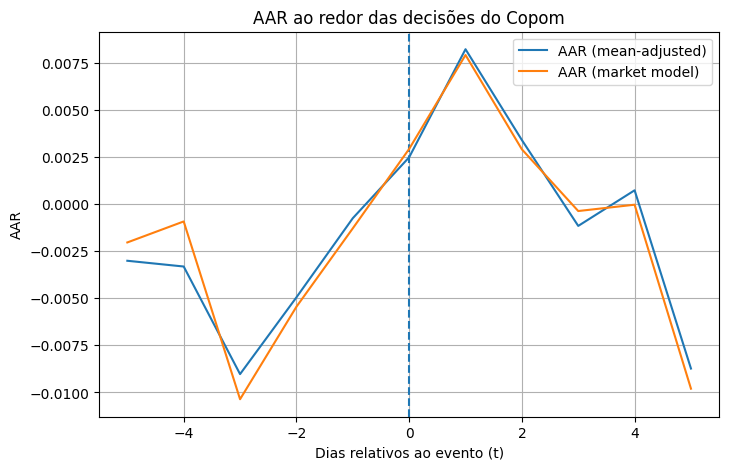

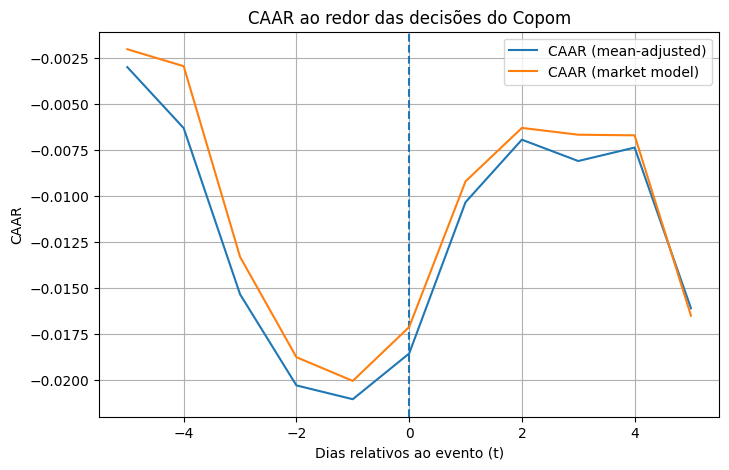

Mean-adjusted — t ∈ {0,1,2}:


,t,AAR,p_value,CAAR
0,0,0.002485,0.657422,-0.018575
1,1,0.008222,0.039513,-0.010353
2,2,0.003399,0.515021,-0.006954


Market model — t ∈ {0,1,2}:


,t,AAR,p_value,CAAR
0,0,0.002929,0.506061,-0.017136
1,1,0.007915,0.030715,-0.009221
2,2,0.002907,0.574216,-0.006314


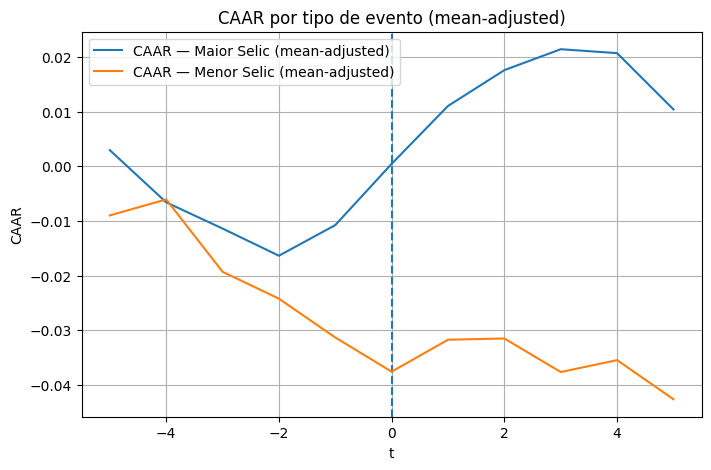

DADOS GERADOS.


In [ ]:
# ----------------- 7) Gráficos -----------------
# AAR
plt.figure()
plt.axvline(0, linestyle='--')
plt.plot(agg_ma['t'], agg_ma['AAR'], label='AAR (mean-adjusted)')
plt.plot(agg_mm['t'], agg_mm['AAR'], label='AAR (market model)')
plt.title('AAR ao redor das decisões do Copom')
plt.xlabel('Dias relativos ao evento (t)')
plt.ylabel('AAR')
plt.legend(); plt.grid(True)
plt.show()

# CAAR
plt.figure()
plt.axvline(0, linestyle='--')
plt.plot(agg_ma['t'], agg_ma['CAAR'], label='CAAR (mean-adjusted)')
plt.plot(agg_mm['t'], agg_mm['CAAR'], label='CAAR (market model)')
plt.title('CAAR ao redor das decisões do Copom')
plt.xlabel('Dias relativos ao evento (t)')
plt.ylabel('CAAR')
plt.legend(); plt.grid(True)
plt.show()

# ----------------- 8) Sumário rápido (t = 0, +1, +2) -----------------
def pick_rows(agg, ts=[0,1,2]):
    return agg[agg['t'].isin(ts)][['t','AAR','p_value','CAAR']].reset_index(drop=True)

print("Mean-adjusted — t ∈ {0,1,2}:")
display(pick_rows(agg_ma))
print("Market model — t ∈ {0,1,2}:")
display(pick_rows(agg_mm))

# ----------------- 9) (Opcional) Comparar por tipo de evento -----------------
def aggregate_by_obs(df, obs_value, ar_col='AR_ma', car_col='CAR_ma'):
    sub = df[df['obs'] == obs_value]
    if sub.empty:
        return None
    agg = sub.groupby('t').agg(
        AAR=(ar_col,'mean'),
        CAAR=(car_col,'mean'),
        N=(ar_col,'count'),
        SD_AR=(ar_col,'std')
    ).reset_index()
    agg['t_stat'] = agg['AAR'] / (agg['SD_AR'] / np.sqrt(agg['N']))
    agg['p_value'] = 2 * (1 - stats.t.cdf(np.abs(agg['t_stat']), df=agg['N']-1))
    return agg

agg_ma_maior = aggregate_by_obs(ev_df, 'Maior Selic', 'AR_ma', 'CAR_ma')
agg_ma_menor = aggregate_by_obs(ev_df, 'Menor Selic', 'AR_ma', 'CAR_ma')

if agg_ma_maior is not None and agg_ma_menor is not None:
    plt.figure()
    plt.axvline(0, linestyle='--')
    plt.plot(agg_ma_maior['t'], agg_ma_maior['CAAR'], label='CAAR — Maior Selic (mean-adjusted)')
    plt.plot(agg_ma_menor['t'], agg_ma_menor['CAAR'], label='CAAR — Menor Selic (mean-adjusted)')
    plt.title('CAAR por tipo de evento (mean-adjusted)')
    plt.xlabel('t'); plt.ylabel('CAAR')
    plt.legend(); plt.grid(True)
    plt.show()

print("DADOS GERADOS.")

##  Boas práticas
- Baselines estabelecidos:  
   
  - Estudo de eventos: mean-adjusted model como referência simples.  
- Seeds fixados (`np.random.seed(42)`) para reprodutibilidade.  
- Documentação clara das escolhas de janelas e parâmetros.  
- **Recursos computacionais**: experimentos realizados em Google Colab, com CPU padrão; tempo de treino < 1 minuto para todos os modelos.  
- Todos os resultados (métricas, gráficos e tabelas) foram reportados e discutidos.

---

## Resultados principais

- **Estudo de eventos**:  
  - O IFNC não apresentou reação significativa no próprio dia do Copom (t=0).  
  - No dia seguinte (t=+1), houve retorno anormal **positivo e estatisticamente significativo** (~0,8%).  
  - O efeito desaparece após t=+2.  
  - Eventos de **alta da Selic** geraram reações positivas no IFNC, enquanto eventos de **queda da Selic** foram associados a quedas no índice.

---

## Conclusão e próximos passos
- O MVP atendeu aos requisitos: preparação, modelagem, validação, avaliação e documentação.  
- O estudo mostrou que as decisões do Copom têm efeito de curto prazo no setor financeiro.  
- **Limitações**: número pequeno de eventos analisados; retornos financeiros são altamente voláteis e ruidosos.  
- **Próximos passos**: ampliar a amostra com todas as reuniões do Copom, testar diferentes janelas de evento, separar impactos por governo, e avaliar outros setores além do IFNC.